| Lang |  Threshold |  Num Docs | Num Sys | Num Sys * Num Docs | Total |
| -------- |  -------- | ------- | -------- | ------- | -------- |
| en_nl | 35 |  27 | 5 | 135 | 3830 |
| en_pt | 28 | 41 | 5 | 205 | 4700 |
| en_de | 31 | 36 | 7 | 252 | 6629 |
| en_ko | 48 | 24 | 4 | 96 |  3648 |
| en_fr | 33 | 37 | 6 | 222 | 6324 |

In [ ]:
import pandas as pd
import collections
import json

lang_dict = {"en": "eng", "de": "deu", "pt": "por", "fr": "fra", "ko": "kor", "nl": "nld"}

for lp in ["en-de", "en-fr", "en-ko", "en-nl", "en-pt"]:

  tgt_lang = lp.split("-")[1]
  scores_df = pd.read_csv(f"human_eval/docsqm2{lang_dict[tgt_lang]}_ann.csv")

  scores_df.drop_duplicates(subset=['model_app'], keep='last', inplace=True)

  print(f"language Pair: {lp} #(Document-level) {len(scores_df[scores_df.is_doc==True])} #(Sentence-level) {len(scores_df[scores_df.is_doc==False])} #Total: {len(scores_df)}")
  print("============= Document-level ===========")
  print(scores_df[scores_df.is_doc==True].groupby("model")["score"].mean())

  main_df = pd.read_csv(f"all_submissions/{lp}.csv")
  all_df = []
  for gr, gr_df in main_df.groupby("doc_id"):
    gr_df["seg_id"] = list(range(0, len(gr_df)))
    all_df.append(gr_df)
  all_df = pd.concat(all_df)

  assert collections.Counter(scores_df["model"].unique()) == collections.Counter(all_df.columns[8:-1])

  all_df = all_df.melt(id_vars=['source_language', 'target_language', 'source', 'reference', 'doc_id', 'client_id', 'sender', 'tags', 'seg_id'],
                       value_vars=all_df.columns[8:-1], var_name="model", value_name="output")
  all_df.rename(columns={"seg_id": "sent_id"}, inplace=True)

  new_df = scores_df[scores_df.is_doc==False].merge(all_df, on=["doc_id", "sent_id", "model"])
  assert len(scores_df[scores_df.is_doc==False]) == len(new_df)

  for sub_lp, sub_lp_df in new_df.groupby(["source_language", "target_language"]):
    print("============== Sentence-level ===========")
    print(f"Language Direction: {sub_lp[0]} ->  {sub_lp[1]}")
    print(sub_lp_df.groupby("model")["score"].mean())

  print("\n\n")

# Paper Analysis

In [28]:
import pandas as pd
import collections
import json

lang_dict = {"en": "eng", "de": "deu", "pt": "por", "fr": "fra", "ko": "kor", "nl": "nld"}


for lp in ["en-de", "en-fr", "en-ko", "en-nl", "en-pt"]:

  tgt_lang = lp.split("-")[1]
  scores_df = pd.read_csv(f"human_eval/docsqm2{lang_dict[tgt_lang]}_ann.csv")
  scores_df.drop_duplicates(subset=['model_app'], keep='last', inplace=True)

  main_df = pd.read_csv(f"all_submissions/{lp}.csv")
  all_df = []
  for gr, gr_df in main_df.groupby("doc_id"):
    gr_df["seg_id"] = list(range(0, len(gr_df)))
    all_df.append(gr_df)
  all_df = pd.concat(all_df)

  all_df = all_df.melt(id_vars=['source_language', 'target_language', 'source', 'reference', 'doc_id', 'client_id', 'sender', 'tags', 'seg_id'],
                       value_vars=all_df.columns[8:-1], var_name="model", value_name="output")
  all_df.rename(columns={"seg_id": "sent_id"}, inplace=True)
  
  turn_df = scores_df[scores_df.is_doc==False].merge(all_df, on=["doc_id", "sent_id", "model"])

  scores = []
  for gr, gr_df in turn_df.groupby(['doc_id', 'model']):
    scores.append([lp, gr[0], gr[1], gr_df['score'].mean(), scores_df[(scores_df.doc_id==gr[0]) & (scores_df.model==gr[1]) & (scores_df.is_doc==True)]['score'].values[0]])


In [29]:
scores_df = pd.DataFrame(scores)
scores_df.columns = ["lp", "score-type", "model", "Avg Turn DA", "Conversation DA"]

In [30]:
scores_df[["Avg Turn DA", "Conversation DA"]].corr(method='spearman')

,Avg Turn DA,Conversation DA
Avg Turn DA,1.000000,0.722486
Conversation DA,0.722486,1.000000


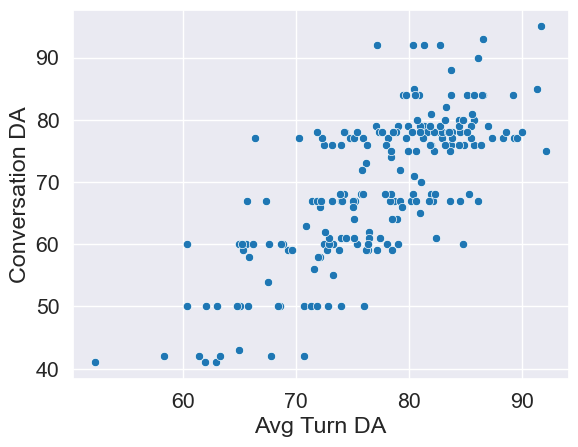

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(
    rc={"patch.force_edgecolor": True, "patch.edgecolor": "black", "font": "Palatino"}
)
sns.set_style("ticks")

plt.rcParams["font.family"] = "Palatino"
plt.rcParams["font.size"] = 10

# Setting the Seaborn context to adjust font sizes
sns.set_context("notebook", font_scale=1.4)
with sns.axes_style("darkgrid"):
    sns.scatterplot(scores_df, x='Avg Turn DA', y='Conversation DA')

plt.savefig('turn_vs_conv.pdf', dpi=100, bbox_inches='tight')

# Segment/Conv analysis

In [1]:
import pandas as pd
import collections
import json

lang_dict = {"en": "eng", "de": "deu", "pt": "por", "fr": "fra", "ko": "kor", "nl": "nld"}

scores = []
for lp in ["en-de", "en-fr", "en-ko", "en-nl", "en-pt"]:

  tgt_lang = lp.split("-")[1]
  scores_df = pd.read_csv(f"human_eval/docsqm2{lang_dict[tgt_lang]}_ann.csv")
  scores_df.drop_duplicates(subset=['model_app'], keep='last', inplace=True)

  for gr, gr_df in scores_df[scores_df.is_doc==True].groupby(['doc_id', 'model']):
    scores.append([lp, gr[0], gr[1].split("submission_")[1].replace('DeepText_Lab','DeepText Lab').replace('clteam','CLTeam').replace('unbabel+it','Unbabel-IT').replace('baseline','NLLB-3.3B'), gr_df.score.values[0]])


df_scores = pd.DataFrame(scores)
df_scores.columns = ["LP", "doc", "Model", "DA"]

In [2]:
df_scores["LP"] = df_scores["LP"].apply(lambda x: x.upper())

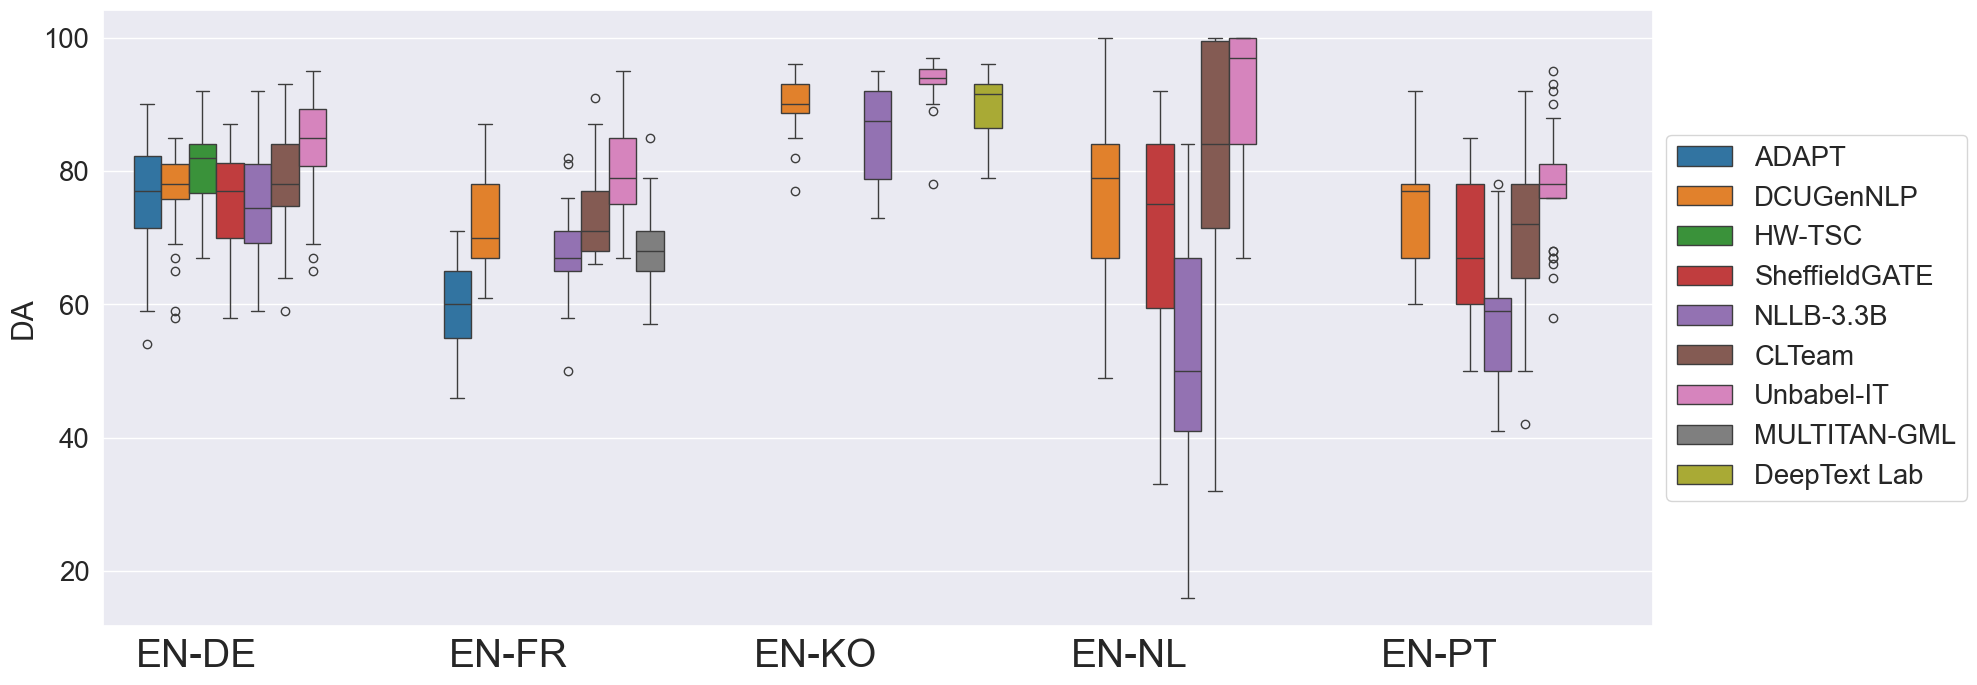

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.rc("text", usetex=True)
sns.set_style(
    rc={"patch.force_edgecolor": True, "patch.edgecolor": "black", "font": "Palatino"}
)
sns.set_style("ticks")

plt.figure(figsize=(20, 8))

# Setting the Seaborn context to adjust font sizes
sns.set_context("notebook", font_scale=1.8)
with sns.axes_style("darkgrid"):
    sns.boxplot(data=df_scores, x="LP", y="DA", hue="Model", width=0.8, dodge=True)

plt.xlabel("")  
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(ticks=plt.xticks()[0], ha='right',  fontsize=28)  # Increase font size


plt.savefig('plots/conv_scores.pdf', dpi=100, bbox_inches='tight')

In [6]:
import pandas as pd
import collections
import json

lang_dict = {"en": "eng", "de": "deu", "pt": "por", "fr": "fra", "ko": "kor", "nl": "nld"}

scores = []
for lp in ["en-de", "en-fr", "en-ko", "en-nl", "en-pt"]:

  tgt_lang = lp.split("-")[1]
  scores_df = pd.read_csv(f"human_eval/docsqm2{lang_dict[tgt_lang]}_ann.csv")
  scores_df.drop_duplicates(subset=['model_app'], keep='last', inplace=True)

  for gr, gr_df in scores_df[scores_df.is_doc==False].groupby(['doc_id', 'sent_id', 'model']):
    scores.append([lp, gr[0], gr[1], gr[2].split("submission_")[1].replace('DeepText_Lab','DeepText Lab').replace('clteam','CLTeam').replace('unbabel+it','Unbabel-IT').replace('baseline','NLLB-3.3B'), gr_df.score.values[0]])


df_scores = pd.DataFrame(scores)
df_scores.columns = ["LP", "doc", "Turn No.", "Model", "DA"]

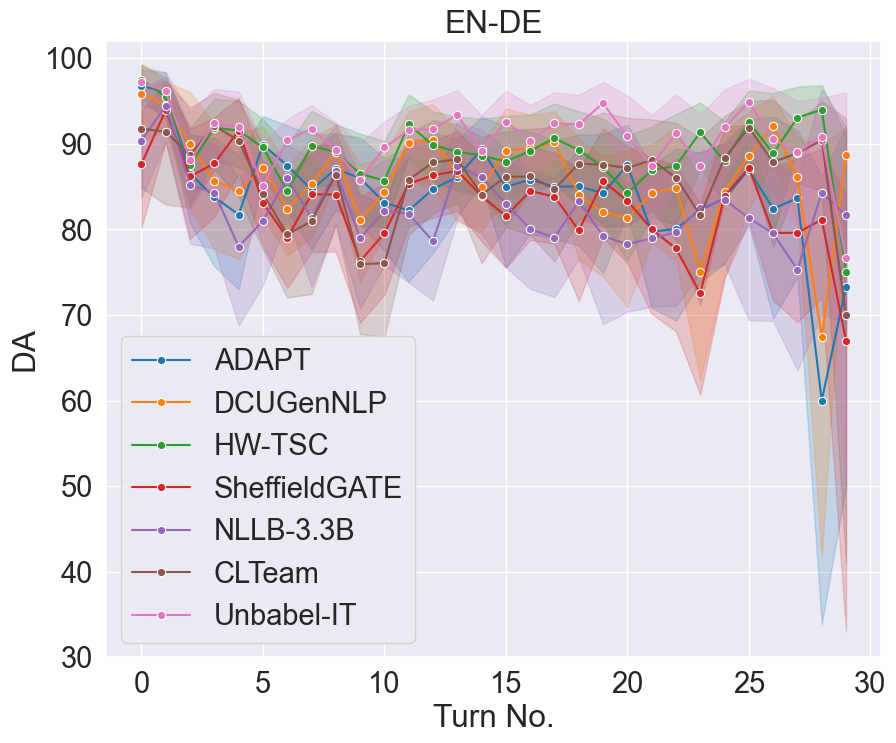

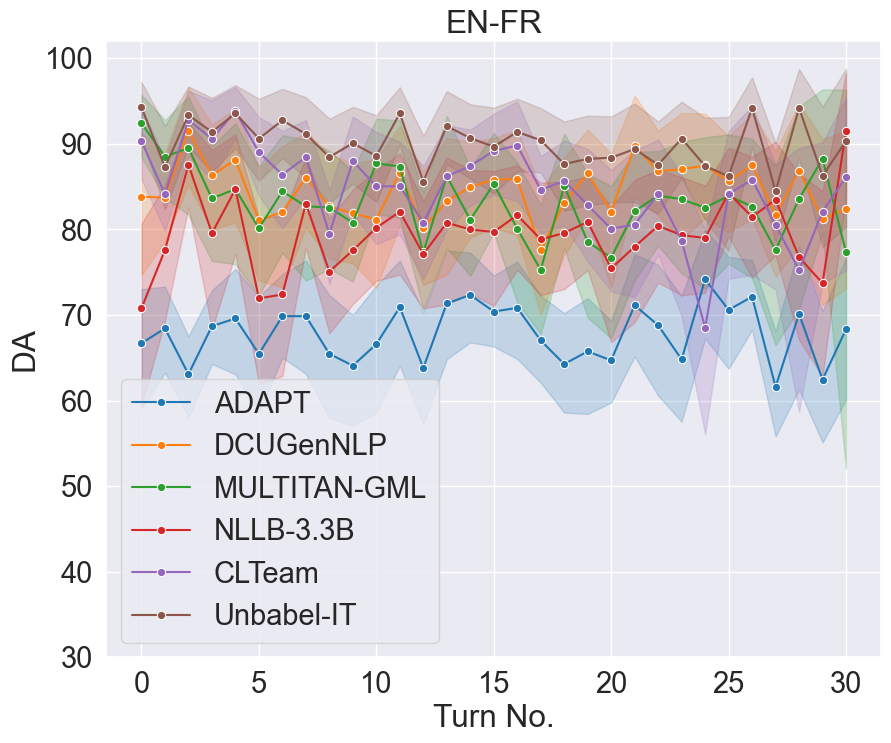

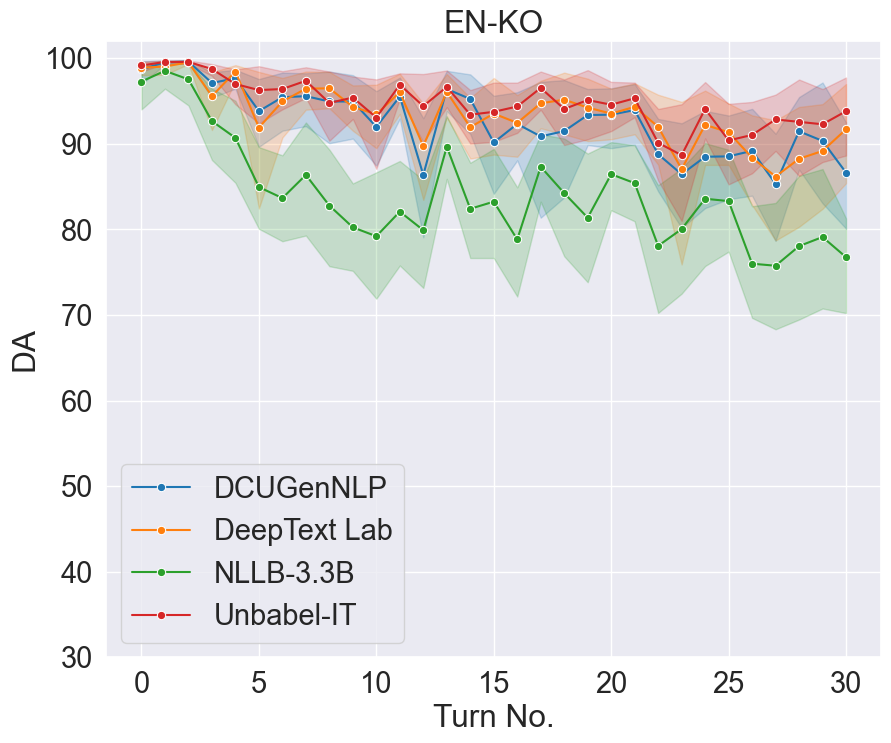

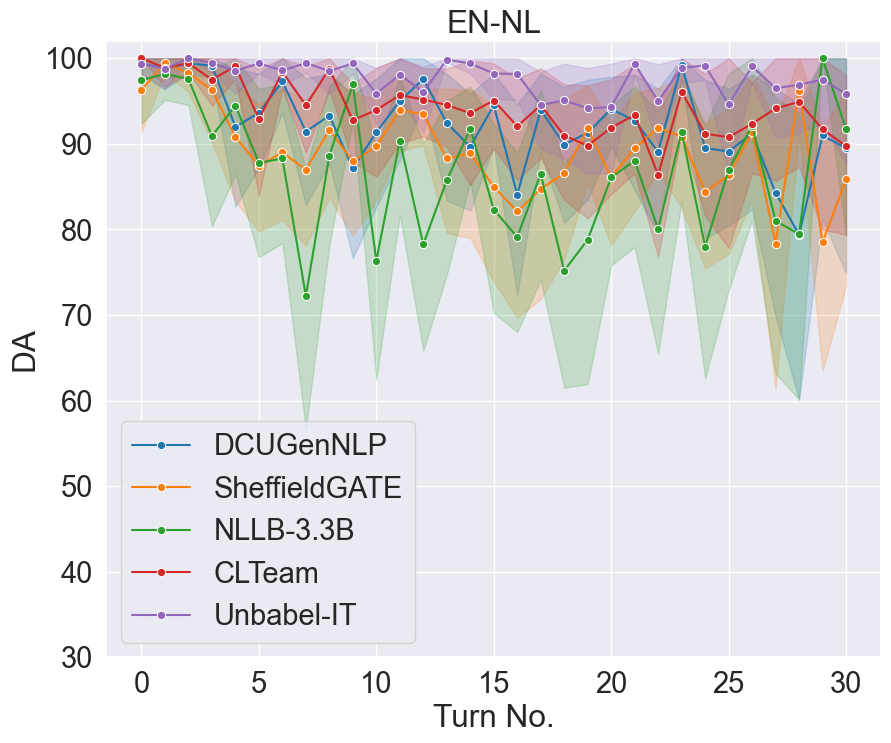

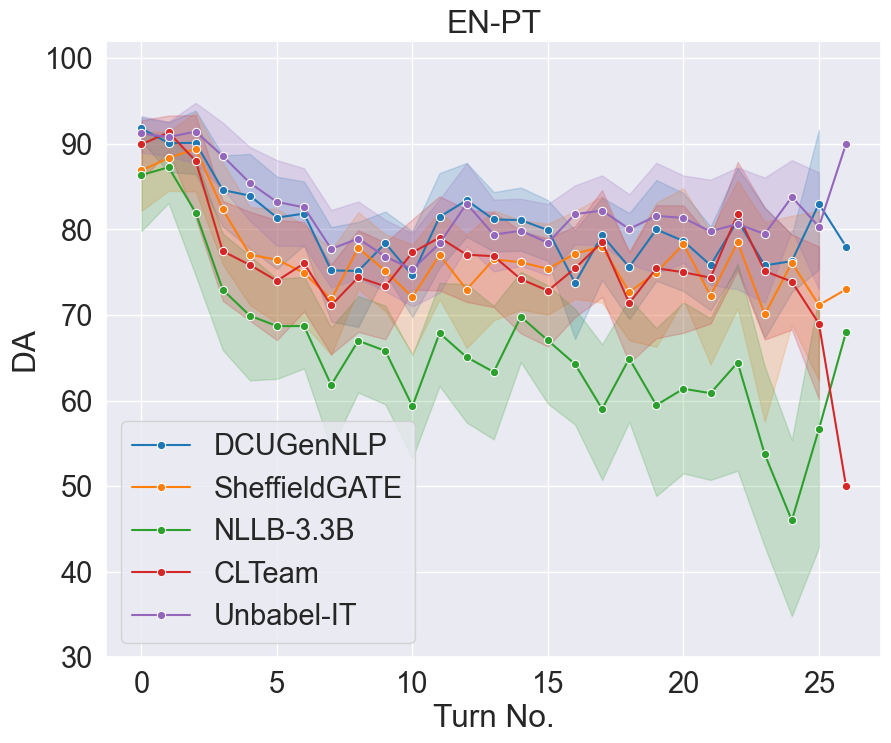

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(
    rc={"patch.force_edgecolor": True, "patch.edgecolor": "black", "font": "Palatino"}
)
sns.set_style("ticks")

# plt.figure(figsize=(10, 8))

# Setting the Seaborn context to adjust font sizes
sns.set_context("notebook", font_scale=1.9)
with sns.axes_style("darkgrid"):
    
    # Create a FacetGrid with line plots to show trends for each LP
    for lp, lp_df in df_scores[(df_scores["Turn No."] <= 30)].groupby("LP"):
        plt.figure(figsize=(10, 8))
        ax = sns.lineplot(data=lp_df, x="Turn No.", y="DA", hue="Model", marker="o")
        ax.legend(loc='lower left')
        plt.ylim(30, 102)
        plt.title(f"{lp.upper()}")
        plt.title(f'EN-{lp.upper()}')
        # plt.show()

        plt.savefig(f'turn_scores_LP_{lp}.pdf', dpi=150, bbox_inches='tight')
